In [1]:
#Importing the libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
import seaborn as sns

In [2]:
#Softmax Function

def soft_max_fun (stimuli_values, beta):
    choices_probabilities = np.exp(stimuli_values*beta)/np.sum(np.exp(stimuli_values*beta))
    return choices_probabilities

In [3]:
#Reward Generation Function

def reward_seq_gen (task_volatility_sequence, probability_sequence, true_choices):
    reward_probability_sequence_choice1 = []
    reward_probability_sequence_choice2 = []
    true_choices_sequence = []
    reward_sequence_choice1 = []
    reward_sequence_choice2 = []
    for i in range(len(task_volatility_sequence)):
        for j in range(task_volatility_sequence[i]):
            reward_probability_sequence_choice1.append(probability_sequence[i])
            reward_probability_sequence_choice2.append(round(1 - probability_sequence[i], 2))
            true_choices_sequence.append(true_choices[i])
            if np.random.rand() <= probability_sequence[i]:
                reward_sequence_choice1.append(1)
                reward_sequence_choice2.append(0)
            else:
                reward_sequence_choice1.append(0)
                reward_sequence_choice2.append(1)
    return np.array(reward_sequence_choice1), np.array(reward_sequence_choice2), np.array(true_choices_sequence), np.array(reward_probability_sequence_choice1), np.array(reward_probability_sequence_choice2)

In [4]:
#Choice Value Calculation Function

def choice_val_calc(trials_num, beta, alpha, initial_choices_values, reward_sequence_choice1, reward_sequence_choice2):  
    choices_values = np.zeros((trials_num+1, 2))
    choices_values[0, :] = initial_choices_values
    softmax_values = np.zeros((trials_num+1, 2))
    choices = np.zeros(trials_num)
    for i in range(trials_num):
        softmax_choices_probabilities = soft_max_fun(choices_values[i, :], beta)
        softmax_values[i, :] = softmax_choices_probabilities
        if np.random.rand() <= softmax_choices_probabilities[0]:
            choices[i] = 0
            reward = reward_sequence_choice1[i]
            choices_values[i+1, 0] = choices_values[i, 0] + alpha*(reward - choices_values[i, 0])
            choices_values[i+1, 1] = choices_values[i, 1]
        else:
            choices[i] = 1
            reward = reward_sequence_choice2[i]
            choices_values[i+1, 1] = choices_values[i, 1] + alpha*(reward - choices_values[i, 1])
            choices_values[i+1, 0] = choices_values[i, 0]
    return choices, choices_values, softmax_values

In [5]:
#Results Plotting Function

def result_plot(choice_to_plot, subjects_num_to_plot, trials_num, reward_probability_sequence_choice1, reward_probability_sequence_choice2, choices, choices_values, softmax_values):
        
    if choice_to_plot == 1:
        choices_to_plot = 1-choices
        reward_probability_to_plot = reward_probability_sequence_choice1
        other_choice = 2
    elif choice_to_plot == 2:
        choices_to_plot = choices
        reward_probability_to_plot = reward_probability_sequence_choice2
        other_choice = 1
        
    fig, ax = plt.subplots()
    
    if subjects_num_to_plot == 1:
        ax.plot(choices_to_plot[:, 0], linestyle='None', marker = "*", color = "k", label = 'Choice')
    elif subjects_num_to_plot > 1:
        ax.plot(np.mean(uniform_filter1d(choices_to_plot[:, 0:subjects_num_to_plot], size=10) , 1), color = 'k', label = str('Mean of Choice' + str(choice_to_plot)))
    
    ax.plot(reward_probability_to_plot, label = str('p(Reward|Choice' + str(choice_to_plot) + ')'))
    ax.plot(np.mean(softmax_values[0:trials_num, choice_to_plot-1, 0:subjects_num_to_plot], 1), color = 'r', label = str('p(Choice' + str(choice_to_plot) + ')'))
    ax.plot(np.mean(choices_values[0:trials_num, choice_to_plot-1, 0:subjects_num_to_plot], 1), color = 'g', label = str('Value of Choice' + str(choice_to_plot)))
    ax.plot(np.mean(choices_values[0:trials_num, other_choice-1, 0:subjects_num_to_plot], 1), color = 'y', label = str('Value of Choice' + str(other_choice)))
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(xlabel='Trial', ylabel=str('p(Reward|Choice' + str(choice_to_plot) + ')'), title='Choice Dynamics')
    ax.set_ylim([0, 1])

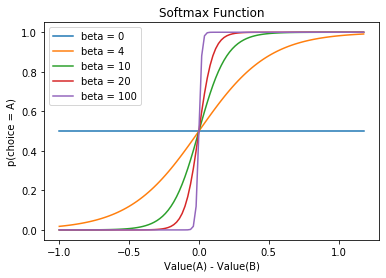

In [6]:
# Plotting softmax function at different beta values

choices_prob_range = np.arange(0.0, 1.1, 0.01)
beta_values = [0, 4, 10, 20, 100]
softmax_prob_values = np.zeros((len(beta_values), len(choices_prob_range), 2))

beta_count = 0
for beta in beta_values:
    value_count = 0
    for value in choices_prob_range:
        choices_values = np.array([value, 1 - value])
        softmax_prob = soft_max_fun(choices_values, beta)
        softmax_prob_values[beta_count, value_count, :] = softmax_prob
        value_count += 1
    plt.plot(2*choices_prob_range - 1, softmax_prob_values[beta_count, :, 0], label = 'beta = ' + str(beta))
    beta_count += 1
    
plt.title('Softmax Function')
plt.legend()
plt.xlabel('Value(A) - Value(B)')
plt.ylabel('p(choice = A)')
plt.show()

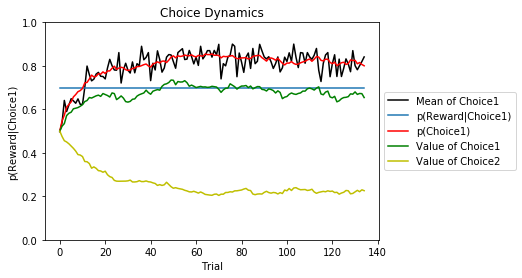

In [7]:
# Data simulation with constant reward probability for each choice

volatility_sequence = [[135]]
high_prop = 0.7
task_volatility_version = 0
subjects_num = 100
alpha = 0.25
beta = 4
initial_choices_values = np.array([0.5, 0.5])
choice_to_plot = 1
subjects_num_to_plot = 100

task_volatility_sequence = volatility_sequence[task_volatility_version]
probability_list = [high_prop, round(1-high_prop, 2)]
probability_sequence = [probability_list[0]]
true_choices = [0]*task_volatility_sequence[0]
trials_num = sum(task_volatility_sequence)

choices_values = np.zeros((trials_num+1, 2, subjects_num))
softmax_values = np.zeros((trials_num+1, 2, subjects_num))
choices = np.zeros((trials_num, subjects_num))

for subject in range(subjects_num):
    reward_sequence_choice1, reward_sequence_choice2, true_choices_sequence, reward_probability_sequence_choice1, reward_probability_sequence_choice2 = reward_seq_gen (task_volatility_sequence, probability_sequence, true_choices)
    choices[:, subject], choices_values[:, :, subject], softmax_values[:, :, subject] = choice_val_calc(trials_num, beta, alpha, initial_choices_values, reward_sequence_choice1, reward_sequence_choice2)

result_plot(choice_to_plot, subjects_num_to_plot, trials_num, reward_probability_sequence_choice1, reward_probability_sequence_choice2, choices, choices_values, softmax_values)

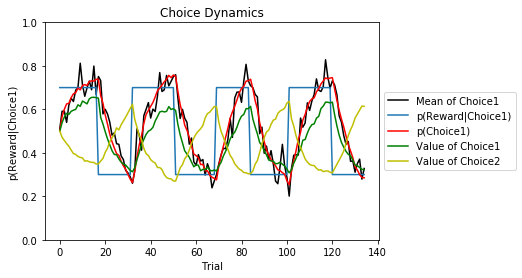

In [8]:
# Data simulation with volatility

volatility_sequence = [[17, 15, 19, 18, 15, 17, 19, 15], [35, 30, 35, 35]]
high_prop = 0.7
task_volatility_version = 0
subjects_num = 100
alpha = 0.25
beta = 4
initial_choices_values = np.array([0.5, 0.5])
choice_to_plot = 1
subjects_num_to_plot = 100

task_volatility_sequence = volatility_sequence[task_volatility_version]
probability_list = [high_prop, round(1-high_prop, 2)]
probability_sequence = probability_list*(int(len(task_volatility_sequence)/2))
true_choices = [0, 1]*(int(len(task_volatility_sequence)/2))
trials_num = sum(task_volatility_sequence)

choices_values = np.zeros((trials_num+1, 2, subjects_num))
softmax_values = np.zeros((trials_num+1, 2, subjects_num))
choices = np.zeros((trials_num, subjects_num))

for subject in range(subjects_num):
    reward_sequence_choice1, reward_sequence_choice2, true_choices_sequence, reward_probability_sequence_choice1, reward_probability_sequence_choice2 = reward_seq_gen (task_volatility_sequence, probability_sequence, true_choices)
    choices[:, subject], choices_values[:, :, subject], softmax_values[:, :, subject] = choice_val_calc(trials_num, beta, alpha, initial_choices_values, reward_sequence_choice1, reward_sequence_choice2)
    
result_plot(choice_to_plot, subjects_num_to_plot, trials_num, reward_probability_sequence_choice1, reward_probability_sequence_choice2, choices, choices_values, softmax_values)